In [1]:
import casadi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
import time
import scienceplots
plt.style.use(['science','ieee','high-vis','grid']) # ここでスタイルを設定する

### パラメータ設定

In [2]:
ρ = 1025.0  # 海水密度

# KCS Container Ship
L_pp = 3.057  # 船長Lpp[m]
B = 0.428   # 船幅[m]
d = 0.144  # 喫水[m]
g = 9.81  # 重力加速度[m/s^2]
nabla = 0.122  # 排水量[m^3]　
x_G = -0.045  # 重心位置[m] 
z_G = -0.035 #船体上下重心位置(GM-KM+d)
z_H = 0.072 #喫水中央
m_x_dash = 0.0061  # 付加質量x(無次元)　
m_y_dash = 0.1521  # 付加質量y(無次元)　
GM = 0.008
D_p = 0.105  # プロペラ直径[m]
A_R = 0.0096  # 舵断面積[m^2]
H_R = 0.132  # 舵高さ
x_R = -0.500  # 舵の相対位置
f_α = 3.006  # 直圧力勾配係数　教科書p24
ε = 0.956
t_R = 0.258
a_H = 0.361
x_H_dash = -0.711
γ_R_plus = 0.492
γ_R_minus = 0.338
l_P_dash = -0.7
l_R_dash = -0.755
z_P_dash = 0.55
z_R_dash = 0.556
κ = 0.633
t_P = 0.178
w_P0 = 0.353
x_P_dash = -0.480  # 船長に対するプロペラ位置
J_xx_dash = 0.005
J_zz_dash = 0.0089
a = 0.228
b = 0.0068
α_z = 0.025
z_R = 0.08 #舵の幾何学的図心
h_a = 0.02414
z_W = 0.08
η=D_p / H_R
x_H=x_H_dash * L_pp
m=ρ * nabla
m_x=(0.5 * ρ * (L_pp ** 2) * d) * m_x_dash
m_y=(0.5 * ρ * (L_pp ** 2) * d) * m_y_dash
I_zz=ρ * nabla * ((0.25 * L_pp) ** 2)
I_xx=ρ * nabla * ((0.25 * B) ** 2)
J_xx=(0.5 * ρ * (B ** 4) * d) * J_xx_dash
J_zz=(0.5 * ρ * (L_pp ** 4) * d) * J_zz_dash

In [3]:
k_0 = 0.4892
k_1 = -0.4053
k_2 = -0.0994
R_0_dash = 0.0183
X_vv_dash = -0.0726
X_vr_dash = -0.0424
X_rr_dash = -0.0139
X_vvvv_dash = -0.0760
X_vφ_dash = 0.0200
X_rφ_dash = 0.0205
X_φφ_dash = 0.0013
Y_v_dash = -0.2310
Y_r_dash = 0.0424
Y_vvv_dash = -1.635
Y_vvr_dash = -0.3090
Y_vrr_dash = -0.805
Y_rrr_dash = -0.005
Y_φ_dash = -0.0157
Y_vvφ_dash = 0.5748
Y_vφφ_dash = 0.2288
Y_rrφ_dash = -0.0642
Y_rφφ_dash = -0.1759
N_v_dash = -0.1130
N_r_dash = -0.0446
N_vvv_dash = -0.1653
N_vvr_dash = -0.6094
N_vrr_dash = -0.0349
N_rrr_dash = -0.0344
N_φ_dash = -0.0137
N_vvφ_dash = -0.2948
N_vφφ_dash = -0.0271
N_rrφ_dash = -0.0120
N_rφφ_dash = 0.1383

In [4]:
def v_m(v,r,p):
    return v-x_G*r+z_G*p

def X_H(u,v,r,p,φ):
    U=np.sqrt(u**2+v_m(v,r,p)**2)
    r_dash=casadi.if_else(U==0.0,0.0,r*L_pp/U)
    v_dash=casadi.if_else(U==0.0,0.0,v/U)
    return 0.5*ρ*L_pp*d*U**2*X_H_dash(v_dash,r_dash,φ)

def Y_H(u,v,r,p,φ):
    U=np.sqrt(u**2+v_m(v,r,p)**2)
    r_dash=casadi.if_else(U==0.0,0.0,r*L_pp/U)
    v_dash=casadi.if_else(U==0.0,0.0,v/U)
    return 0.5*ρ*L_pp*d*U**2*Y_H_dash(v_dash,r_dash,φ)

def N_H(u,v,r,p,φ):
    U=np.sqrt(u**2+v_m(v,r,p)**2)
    r_dash=casadi.if_else(U==0.0,0.0,r*L_pp/U)
    v_dash=casadi.if_else(U==0.0,0.0,v/U)
    return 0.5*ρ*L_pp**2*d*U**2*N_H_dash(v_dash,r_dash,φ)

def X_H_dash(v_dash,r_dash,φ):
    return -R_0_dash+X_vv_dash*v_dash**2+X_vr_dash*v_dash*r_dash+X_rr_dash*r_dash**2+X_vvvv_dash*v_dash**4+X_vφ_dash*v_dash*φ+X_rφ_dash*r_dash*φ+X_φφ_dash*φ**2

def Y_H_dash(v_dash,r_dash,φ):
    return Y_v_dash*v_dash+Y_r_dash*r_dash+Y_vvv_dash*v_dash**3+Y_vvr_dash*v_dash**2*r_dash+Y_vrr_dash*v_dash*r_dash**2+Y_rrr_dash*r_dash**3+Y_φ_dash*φ+Y_vvφ_dash*v_dash**2*φ+Y_vφφ_dash*v_dash*φ**2+Y_rrφ_dash*r_dash**2*φ+Y_rφφ_dash*r_dash*φ**2

def N_H_dash(v_dash,r_dash,φ):
    return N_v_dash*v_dash+N_r_dash*r_dash+N_vvv_dash*v_dash**3+N_vvr_dash*v_dash**2*r_dash+N_vrr_dash*v_dash*r_dash**2+N_rrr_dash*r_dash**3+N_φ_dash*φ+N_vvφ_dash*v_dash**2*φ+N_vφφ_dash*v_dash*φ**2+N_rrφ_dash*r_dash**2*φ+N_rφφ_dash*r_dash*φ**2

def X_R(u,v,r,p,φ,δ,n_p):
    return -(1-t_R)*F_N(u,v,r,p,δ,n_p)*np.sin(δ)*np.cos(φ)

def Y_R(u,v,r,p,φ,δ,n_p):
    return -(1+a_H)*F_N(u,v,r,p,δ,n_p)*np.cos(δ)*np.cos(φ)

def N_R(u,v,r,p,φ,δ,n_p):
    return -(x_R+a_H*x_H)*F_N(u,v,r,p,δ,n_p)*np.cos(δ)*np.cos(φ)

def F_N(u,v,r,p,δ,n_p):
    U=np.sqrt(u**2+v_m(v,r,p)**2)
    β=casadi.if_else(u==0.0,0.0,casadi.arctan2(-v_m(v,r,p),u))
    r_dash=casadi.if_else(U==0.0,0.0,r*L_pp/U)
    p_dash=casadi.if_else(U==0.0,0.0,p*B/U)
    β_P=β-l_P_dash*r_dash+z_P_dash*p_dash
    β_R=β-l_R_dash*r_dash+z_R_dash*p_dash
    w_P=w_P0*(1-(1-casadi.cos(β_P)**2)*(1-casadi.fabs(β_P)))
    u_R=casadi.if_else(J(u,v,r,p,n_p)==0.0, casadi.sqrt(η*(κ*ε*8.0*k_0*n_p**2*D_p**4/casadi.pi)**2), u*(1-w_P)*ε*casadi.sqrt(η*(1+κ*(casadi.sqrt(1+(8*K_T(u,v,r,p,n_p))/(casadi.pi*J(u,v,r,p,n_p)**2))-1))**2+(1-η)))
    γ_R=casadi.if_else(β_R<0.0,γ_R_minus,γ_R_plus)
    v_R=U*γ_R*β_R
    α_R=δ-np.arctan2(v_R,u_R)
    U_R=np.sqrt(u_R**2+v_R**2)
    return 0.5*A_R*ρ*f_α*U_R**2*np.sin(α_R)

def X_P(u,v,r,p,n_p):
    return (1-t_P)*ρ*n_p**2*D_p**4*K_T(u,v,r,p,n_p)

def K_T(u,v,r,p,n_p):
    return k_0+k_1*J(u,v,r,p,n_p)+k_2*J(u,v,r,p,n_p)**2

def J(u,v,r,p,n_p):
    U=np.sqrt(u**2+v_m(v,r,p)**2)
    β=casadi.if_else(u==0.0,0.0,casadi.arctan2(-v_m(v,r,p),u))
    r_dash=casadi.if_else(U==0.0,0.0,r*L_pp/U)
    p_dash=casadi.if_else(U==0.0,0.0,p*B/U)
    β_P=β-l_P_dash*r_dash+z_P_dash*p_dash
    w_P=w_P0*(1-(1-casadi.cos(β_P)**2)*(1-casadi.fabs(β_P)))
    return casadi.if_else(n_p==0.0,0.0,u*(1-w_P)/(n_p*D_p))
    
K_p=-2/np.pi*a*np.sqrt(m*g*GM*(I_xx+J_xx))
K_pp=-0.75*b*(180/np.pi)*(I_xx+J_xx)

def X_(u,v,r,p,φ,δ,n_p,X_F):
    return X_H(u,v,r,p,φ)+X_R(u,v,r,p,φ,δ,n_p)+X_P(u,v,r,p,n_p)+X_F

def Y_(u,v,r,p,φ,δ,n_p,Y_F):
    return Y_H(u,v,r,p,φ)+Y_R(u,v,r,p,φ,δ,n_p)+Y_F

def N_(u,v,r,p,φ,δ,n_p,N_F):
    return N_H(u,v,r,p,φ)+N_R(u,v,r,p,φ,δ,n_p)+N_F

def K_(u,v,r,p,φ,δ,n_p,Y_F):
    return -Y_H(u,v,r,p,φ)*z_H-Y_R(u,v,r,p,φ,δ,n_p)*z_R-m*g*GM*φ+K_p*p+K_pp*p*casadi.fabs(p)+z_W*Y_F

def A_():
    return (m+m_y)-(m_y*α_z+m*z_G)**2/(I_xx+J_xx+m*z_G**2)
def B_():
    return x_G*m-(m_y*α_z+m*z_G)*m*z_G*x_G/(I_xx+J_xx+m*z_G**2)
def C_(u,v,r,p,φ,δ,n_p,Y_F):
    return Y_(u,v,r,p,φ,δ,n_p,Y_F)-(m+m_x)*u*r+(m_y*α_z+m*z_G)*(K_(u,v,r,p,φ,δ,n_p,Y_F)+m*z_G*u*r)/(I_xx+J_xx+m*z_G**2)
def D_():
    return m*x_G*(1-z_G*(m_y*α_z+m*z_G)/(I_xx+J_xx+m*z_G**2))
def E_():
    return (I_zz+J_zz+m*x_G**2)-m*z_G**2*x_G/(I_xx+J_xx+m*z_G**2)
def F_(u,v,r,p,φ,δ,n_p,N_F,Y_F):
    return N_(u,v,r,p,φ,δ,n_p,N_F)+m*x_G*(z_G*(K_(u,v,r,p,φ,δ,n_p,Y_F)+m*z_G*u*r)/(I_xx+J_xx+m*z_G**2)-u*r)



In [5]:
# 目標軌道の設定
obs = pd.read_csv('/Users/harukiyamamoto/Documents/M1/4-DOF-simulation-in-waves/mmg_4dof_in_waves.csv')
# obs = pd.read_csv('mmg_4dof_in_waves_miss.csv')
# obs = pd.read_csv('mmg_4dof_in_waves.csv')
obs

,time,u,v,r,p,x,y,psi,phi,X_W,Y_W,N_W,K_W,δ,nps,x_bow,y_bow,x_stern,y_stern
0,0.000000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.913551,0.000000,0.000000,0.000000,0.610865,13.2,1.528500,0.000000,-1.528500,0.000000
1,0.250417,1.477909,-0.013348,0.018192,0.119107,0.372838,-0.001362,0.002357,0.016668,-0.913554,0.000908,0.001538,0.000073,0.610865,13.2,1.901334,0.002240,-1.155658,-0.004964
2,0.500835,1.456760,-0.027112,0.032946,0.146754,0.740291,-0.004485,0.008823,0.051938,-0.913583,0.003400,0.005756,0.000272,0.610865,13.2,2.268732,0.009000,-0.788149,-0.017970
3,0.751252,1.436200,-0.041065,0.045308,0.089188,1.102590,-0.008138,0.018656,0.082984,-0.913683,0.007193,0.012167,0.000575,0.610865,13.2,2.630824,0.020376,-0.425644,-0.036653
4,1.001669,1.415923,-0.055123,0.056604,-0.021955,1.459887,-0.011324,0.031428,0.092180,-0.913895,0.012134,0.020480,0.000971,0.610865,13.2,2.987633,0.036706,-0.067858,-0.059354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,148.998331,0.500499,-0.146025,0.111031,0.000407,-1.050138,5.725696,17.100534,-0.075742,0.092917,-0.320930,-0.217159,-0.025674,0.610865,13.2,-1.321117,4.221408,-0.779160,7.229984
596,149.248748,0.499983,-0.146057,0.110916,0.000462,-1.106708,5.608101,17.128324,-0.075634,0.067049,-0.332530,-0.231987,-0.026602,0.610865,13.2,-1.335783,4.096864,-0.877633,7.119337
597,149.499165,0.499431,-0.146095,0.110785,0.000515,-1.159981,5.489113,17.156083,-0.075511,0.039897,-0.344609,-0.248201,-0.027569,0.610865,13.2,-1.347022,3.972100,-0.972939,7.006126
598,149.749583,0.498842,-0.146140,0.110638,0.000565,-1.209927,5.368836,17.183807,-0.075375,0.011713,-0.356783,-0.265478,-0.028543,0.610865,13.2,-1.354844,3.847222,-1.065011,6.890451


Text(0, 0.5, '$x/L$')

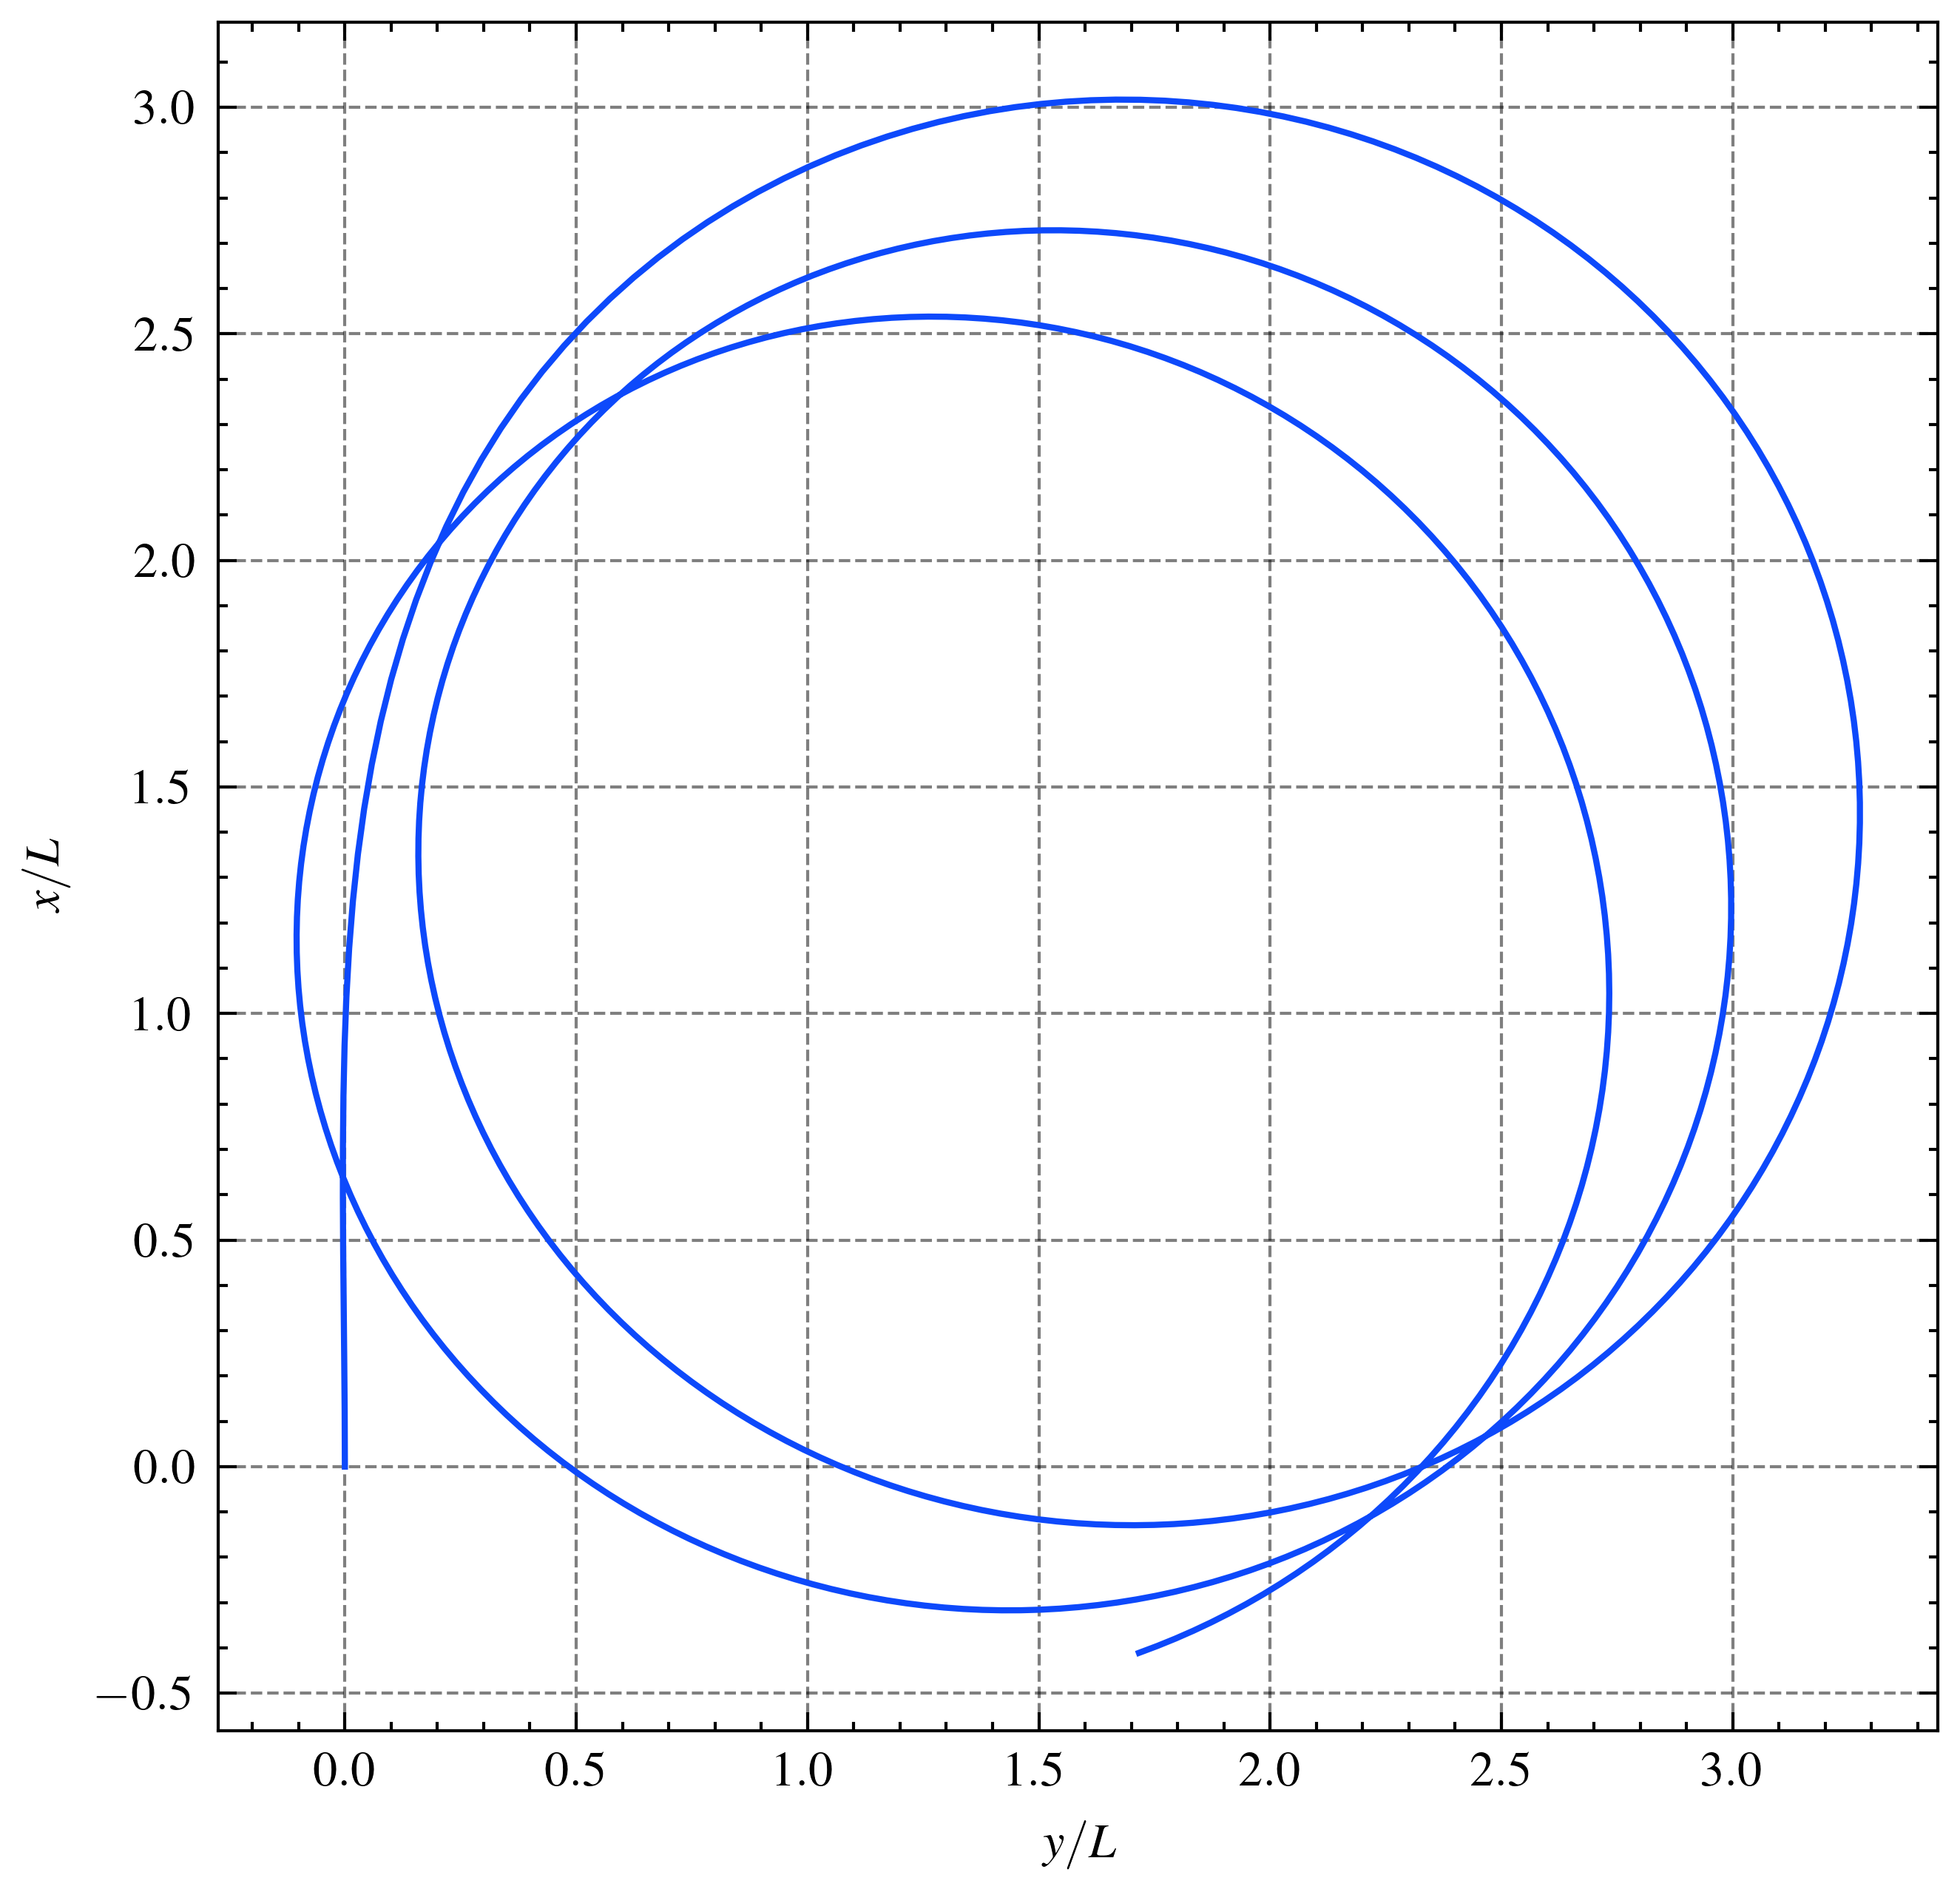

In [6]:
fig = plt.figure(figsize=(5, 5))
plt.plot(obs['y']/L_pp, obs['x']/L_pp)
plt.xlabel("$y/L$")
plt.ylabel("$x/L$")

In [7]:
# 評価関数の重み
Q = casadi.diag([1,1,1,1]) # 状態変数の重み
Q_f = casadi.diag([1,1,1,1])
R = casadi.diag([1e-8,1e-8,1e-8]) # 制御入力の重み

# ホライゾン
K = 10
T = 100
sampling_rate = 4
dt = 1 / sampling_rate

# 制約条件
x_lb = [-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf]
x_ub = [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]
u_lb = [-10, -10, -10]
u_ub = [10, 10, 10]

nx = 13 # 状態変数の次元
nu = 3 # 制御入力の次元

# 目標値
x_ref = casadi.DM(obs[['x_bow', 'y_bow', 'x_stern', 'y_stern']].values)
# u_ref = casadi.DM() 設定しない

# 最適化に現れる全ての変数の次元の合計
total = nx*(K+1) + nu*K

### 状態方程式の設定

In [8]:
def make_f(start=None,end=None,k=None,t=None):
    states = casadi.SX.sym('states', nx)
    ctrls = casadi.SX.sym('ctrls', nu)
    # 状態変数
    u = states[0]
    v = states[1]
    r = states[2]
    p = states[3]
    x_bow = states[4]
    y_bow = states[5]
    x_stern = states[6]
    y_stern = states[7]
    ψ = states[8]
    φ = states[9]
    X_F_m = states[10]
    Y_F_m = states[11]
    N_F_m = states[12]

    if t is not None:
        δ = obs['δ'][t]
        np = obs['nps'][t]
    else:
        δ = obs['δ'][start:end][start+k]
        np = obs['nps'][start:end][start+k]

    # 制御入力
    X_F = ctrls[0]
    Y_F = ctrls[1]
    N_F = ctrls[2]
    
    u_dot = (X_(u,v,r,p,φ,δ,np,X_F)+(m+m_y)*v*r+m*x_G*(r**2)-m*z_G*r*p)/(m+m_x)
    v_dot = (C_(u,v,r,p,φ,δ,np,Y_F)*E_()-B_()*F_(u,v,r,p,φ,δ,np,N_F,Y_F))/(A_()*E_()-B_()*D_())
    r_dot = (C_(u,v,r,p,φ,δ,np,Y_F)*D_()-A_()*F_(u,v,r,p,φ,δ,np,N_F,Y_F))/(B_()*D_()-A_()*E_())
    p_dot = (K_(u,v,r,p,φ,δ,np,Y_F)+(m_y*α_z+m*z_G)*v_dot+m*z_G*(x_G*r_dot+u*r))/(I_xx+J_xx+m*z_G**2)
    x_bow_dot = u*casadi.cos(ψ)-v*casadi.sin(ψ)-0.5*L_pp*r*casadi.sin(ψ)
    y_bow_dot = u*casadi.sin(ψ)+v*casadi.cos(ψ)+0.5*L_pp*r*casadi.cos(ψ)
    x_stern_dot = u*casadi.cos(ψ)-v*casadi.sin(ψ)+0.5*L_pp*r*casadi.sin(ψ)
    y_stern_dot = u*casadi.sin(ψ)+v*casadi.cos(ψ)-0.5*L_pp*r*casadi.cos(ψ)
    ψ_dot = r
    φ_dot = p
    X_F_m_dot = X_F - X_F_m
    Y_F_m_dot = Y_F - Y_F_m
    N_F_m_dot = N_F - N_F_m
    
    states_dot = casadi.vertcat(u_dot, v_dot, r_dot, p_dot, x_bow_dot, y_bow_dot, x_stern_dot, y_stern_dot, ψ_dot, φ_dot, X_F_m_dot, Y_F_m_dot, N_F_m_dot)
    # states_dot = casadi.vertcat(u_dot, v_dot, r_dot, p_dot, x_bow_dot, y_bow_dot, x_stern_dot, y_stern_dot, ψ_dot, φ_dot)
    
    f = casadi.Function('f',[states,ctrls],[states_dot],
                        ['x','u'],['x_dot'])
    return f

In [9]:
obs.keys()

Index(['time', 'u', 'v', 'r', 'p', 'x', 'y', 'psi', 'phi', 'X_W', 'Y_W', 'N_W',
       'K_W', 'δ', 'nps', 'x_bow', 'y_bow', 'x_stern', 'y_stern'],
      dtype='object')

### 連続時間状態方程式の時間離散化

In [10]:
def make_RK4(start,end,k):
    states = casadi.SX.sym('states',nx) # nxの数を設定
    ctrls = casadi.SX.sym('ctrls',nu)
    
    f = make_f(start=start,end=end,k=k)
    
    r1 = f(x=states,u=ctrls)['x_dot']
    r2 = f(x=states+dt*r1/2,u=ctrls)['x_dot']
    r3 = f(x=states+dt*r2/2,u=ctrls)['x_dot']
    r4 = f(x=states+dt*r3,u=ctrls)['x_dot']
    
    states_next = states + dt*(r1+2*r2+2*r3+r4)/6
    
    RK4 = casadi.Function('RK4',[states,ctrls],[states_next],
                          ['x','u'],['x_next'])
    return RK4

### 積分器の作成

In [11]:
def make_integrator(t):
    states = casadi.SX.sym('states',nx)
    ctrls = casadi.SX.sym('ctrls',nu)
    
    f = make_f(t=t)
    ode = f(x=states,u=ctrls)['x_dot']
    
    dae = {'x':states,'p':ctrls,'ode':ode}
    
    I = casadi.integrator('I','cvodes',dae,0,dt)
    return I

### 評価関数

In [12]:
def compute_stage_cost(x,u,x_ref_slice,k):
    x_extract = x[4:8]
    x_diff = x_extract - x_ref_slice[k,:].T
    u_diff = u
    cost = (casadi.dot(Q@x_diff,x_diff)
            + casadi.dot(R@u_diff,u_diff)) / 2
    return cost

def compute_terminal_cost(x,x_ref_slice):
    x_extract = x[4:8]
    x_diff = x_extract - x_ref_slice[-1,:].T
    cost = casadi.dot(Q_f@x_diff,x_diff) / 2
    return cost

In [13]:
def make_nlp(x_ref_slice,start,end):
    # RK4 = make_RK4(start,end,t)
    U = [casadi.SX.sym(f'u_{k}',nu) for k in range(K)]
    X = [casadi.SX.sym(f'x_{k}',nx) for k in range(K+1)]
    G = []
    
    J = 0
    
    for k in range(K):
        RK4 = make_RK4(start,end,k)
        J += compute_stage_cost(X[k],U[k],x_ref_slice,k)*dt #評価関数はC
        eq = X[k+1] - RK4(x=X[k],u=U[k])['x_next']
        G.append(eq) # 制約条件を追加
    J += compute_terminal_cost(X[-1],x_ref_slice)
    
    option = {'print_time':False,
              'ipopt':{'max_iter':500,'print_level':0}}
    nlp = {'x':casadi.vertcat(*X,*U),'f':J,'g':casadi.vertcat(*G)}
    # S = casadi.nlpsol('S','ipopt',nlp)
    S = casadi.nlpsol('S','ipopt',nlp,option)
    return S

### 最適な制御入力を出力する関数

In [14]:
def compute_optimal_control(S,x_init,x0):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + x_lb*K + u_lb*K
    ubx = x_init + x_ub*K + u_ub*K
    lbg = [0]*nx*K
    ubg = [0]*nx*K
    
    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(K+1)
    x0 = res['x']
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

### MPCの実行

In [15]:
t_span = [0,T]
t_eval = np.arange(*t_span,dt)
# 初期値設定
if obs['u'][0]==obs['v'][0]==obs['r'][0]==obs['p']==0:
    x_init = casadi.DM([0.001,0.001,0.001,0.001,obs['x_bow'][0], obs['y_bow'][0], obs['x_stern'][0], obs['y_stern'][0],obs['psi'][0],obs['phi'][0],0,0,0])
else:
    x_init = casadi.DM([obs['u'][0],obs['v'][0],obs['r'][0],obs['p'][0],obs['x_bow'][0], obs['y_bow'][0], obs['x_stern'][0], obs['y_stern'][0],obs['psi'][0],obs['phi'][0],0,0,0])
x0 = casadi.vertcat(x_init,casadi.DM.ones(nx*K),casadi.DM([0,0,0]),casadi.DM.ones(nu*(K-1)))
# x0 = casadi.vertcat(x_init,casadi.DM.ones(nx*K),casadi.DM.ones(nu*K))


X = [x_init]
U = []
x_current = x_init
for t in tqdm(t_eval):
    # tに応じて目標のスライスを決定
    start = int(t/dt)
    end = start + K
    x_ref_slice = x_ref[start:end,:]
    
    S = make_nlp(x_ref_slice,start,end)
    I = make_integrator(start)
    u_opt,x0 = compute_optimal_control(S,x_current,x0)
    x_current = I(x0=x_current,p=u_opt)['xf']
    X.append(x_current)
    U.append(u_opt)
    
X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

  0%|          | 1/400 [00:03<25:15,  3.80s/it]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



100%|██████████| 400/400 [14:45<00:00,  2.21s/it]


### 結果の可視化

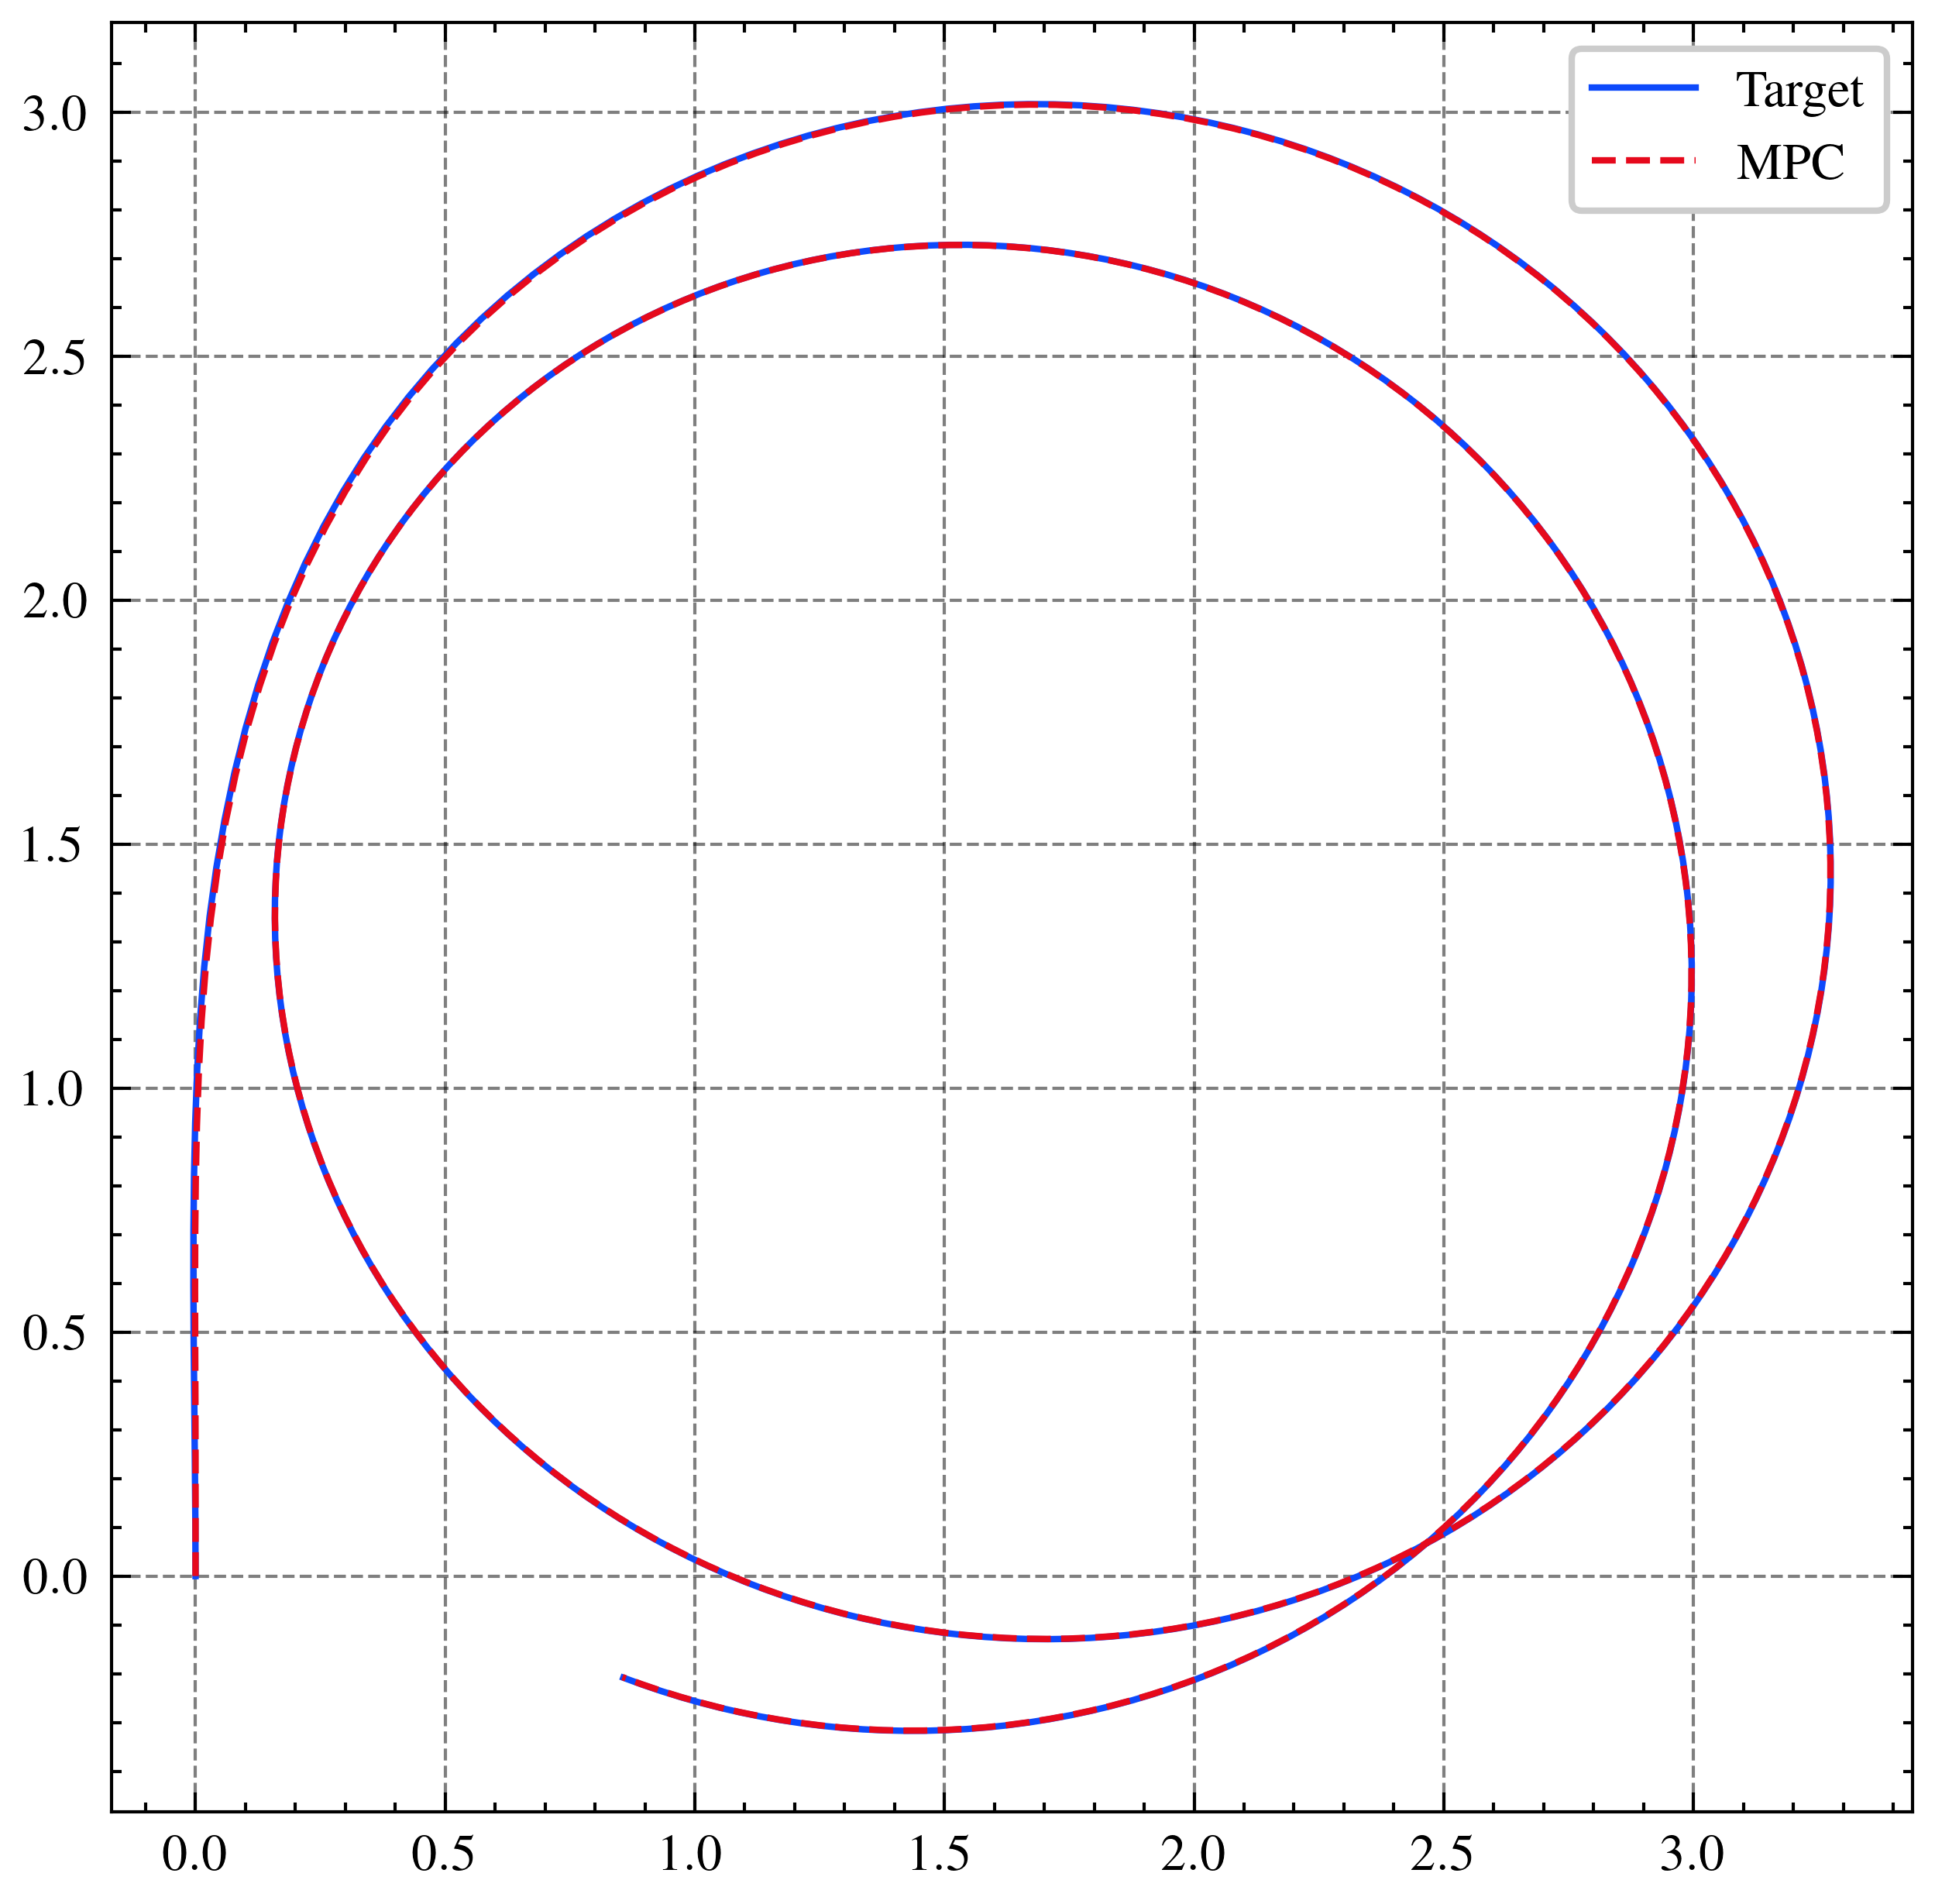

In [16]:
u_ref, v_ref, r_ref, p_ref, x_bow_ref, y_bow_ref, x_stern_ref, y_stern_ref, psi_ref, phi_ref, X_F_ref, Y_F_ref, N_F_ref, K_F_ref = obs[['u', 'v', 'r', 'p', 'x_bow', 'y_bow', 'x_stern', 'y_stern', 'psi', 'phi', 'X_W', 'Y_W', 'N_W', 'K_W']][0:int(T/dt)].values.T
u, v, r, p, x_bow, y_bow, x_stern, y_stern, psi, phi, X_F_Body, Y_F_Body, N_F_Body = X.T
X_F, Y_F, N_F = U.T
fig = plt.figure(figsize=(5, 5))
plt.plot(((y_bow_ref+y_stern_ref)/2)/L_pp, ((x_bow_ref+x_stern_ref)/2)/L_pp, label='Target')
plt.plot(((y_bow+y_stern)/2)/L_pp, ((x_bow+x_stern)/2)/L_pp, label='MPC')
plt.legend()


### 空間固定座標系に変換

In [17]:
X_F_Earth = list(
    map(
        lambda X_F, Y_F, psi:
        X_F * np.cos(psi) - Y_F * np.sin(psi)
        ,
        X_F,
        Y_F,
        psi,
    )
)
Y_F_Earth = list(
    map(
        lambda X_F, Y_F, psi:
        X_F * np.sin(psi) + Y_F * np.cos(psi)
        ,
        X_F,
        Y_F,
        psi,
    )
)
N_F_Earth = N_F

In [18]:
X_F_target = list(
    map(
        lambda X_F, Y_F, psi:
        X_F * np.cos(psi) + Y_F * np.sin(psi)
        ,
        X_F_ref,
        Y_F_ref,
        psi_ref
    )
)
Y_F_target = list(
    map(
        lambda X_F, Y_F, psi:
        -X_F * np.sin(psi) + Y_F * np.cos(psi)
        ,
        X_F_ref,
        Y_F_ref,
        psi_ref
    )
)
N_F_Earth_target = N_F_ref

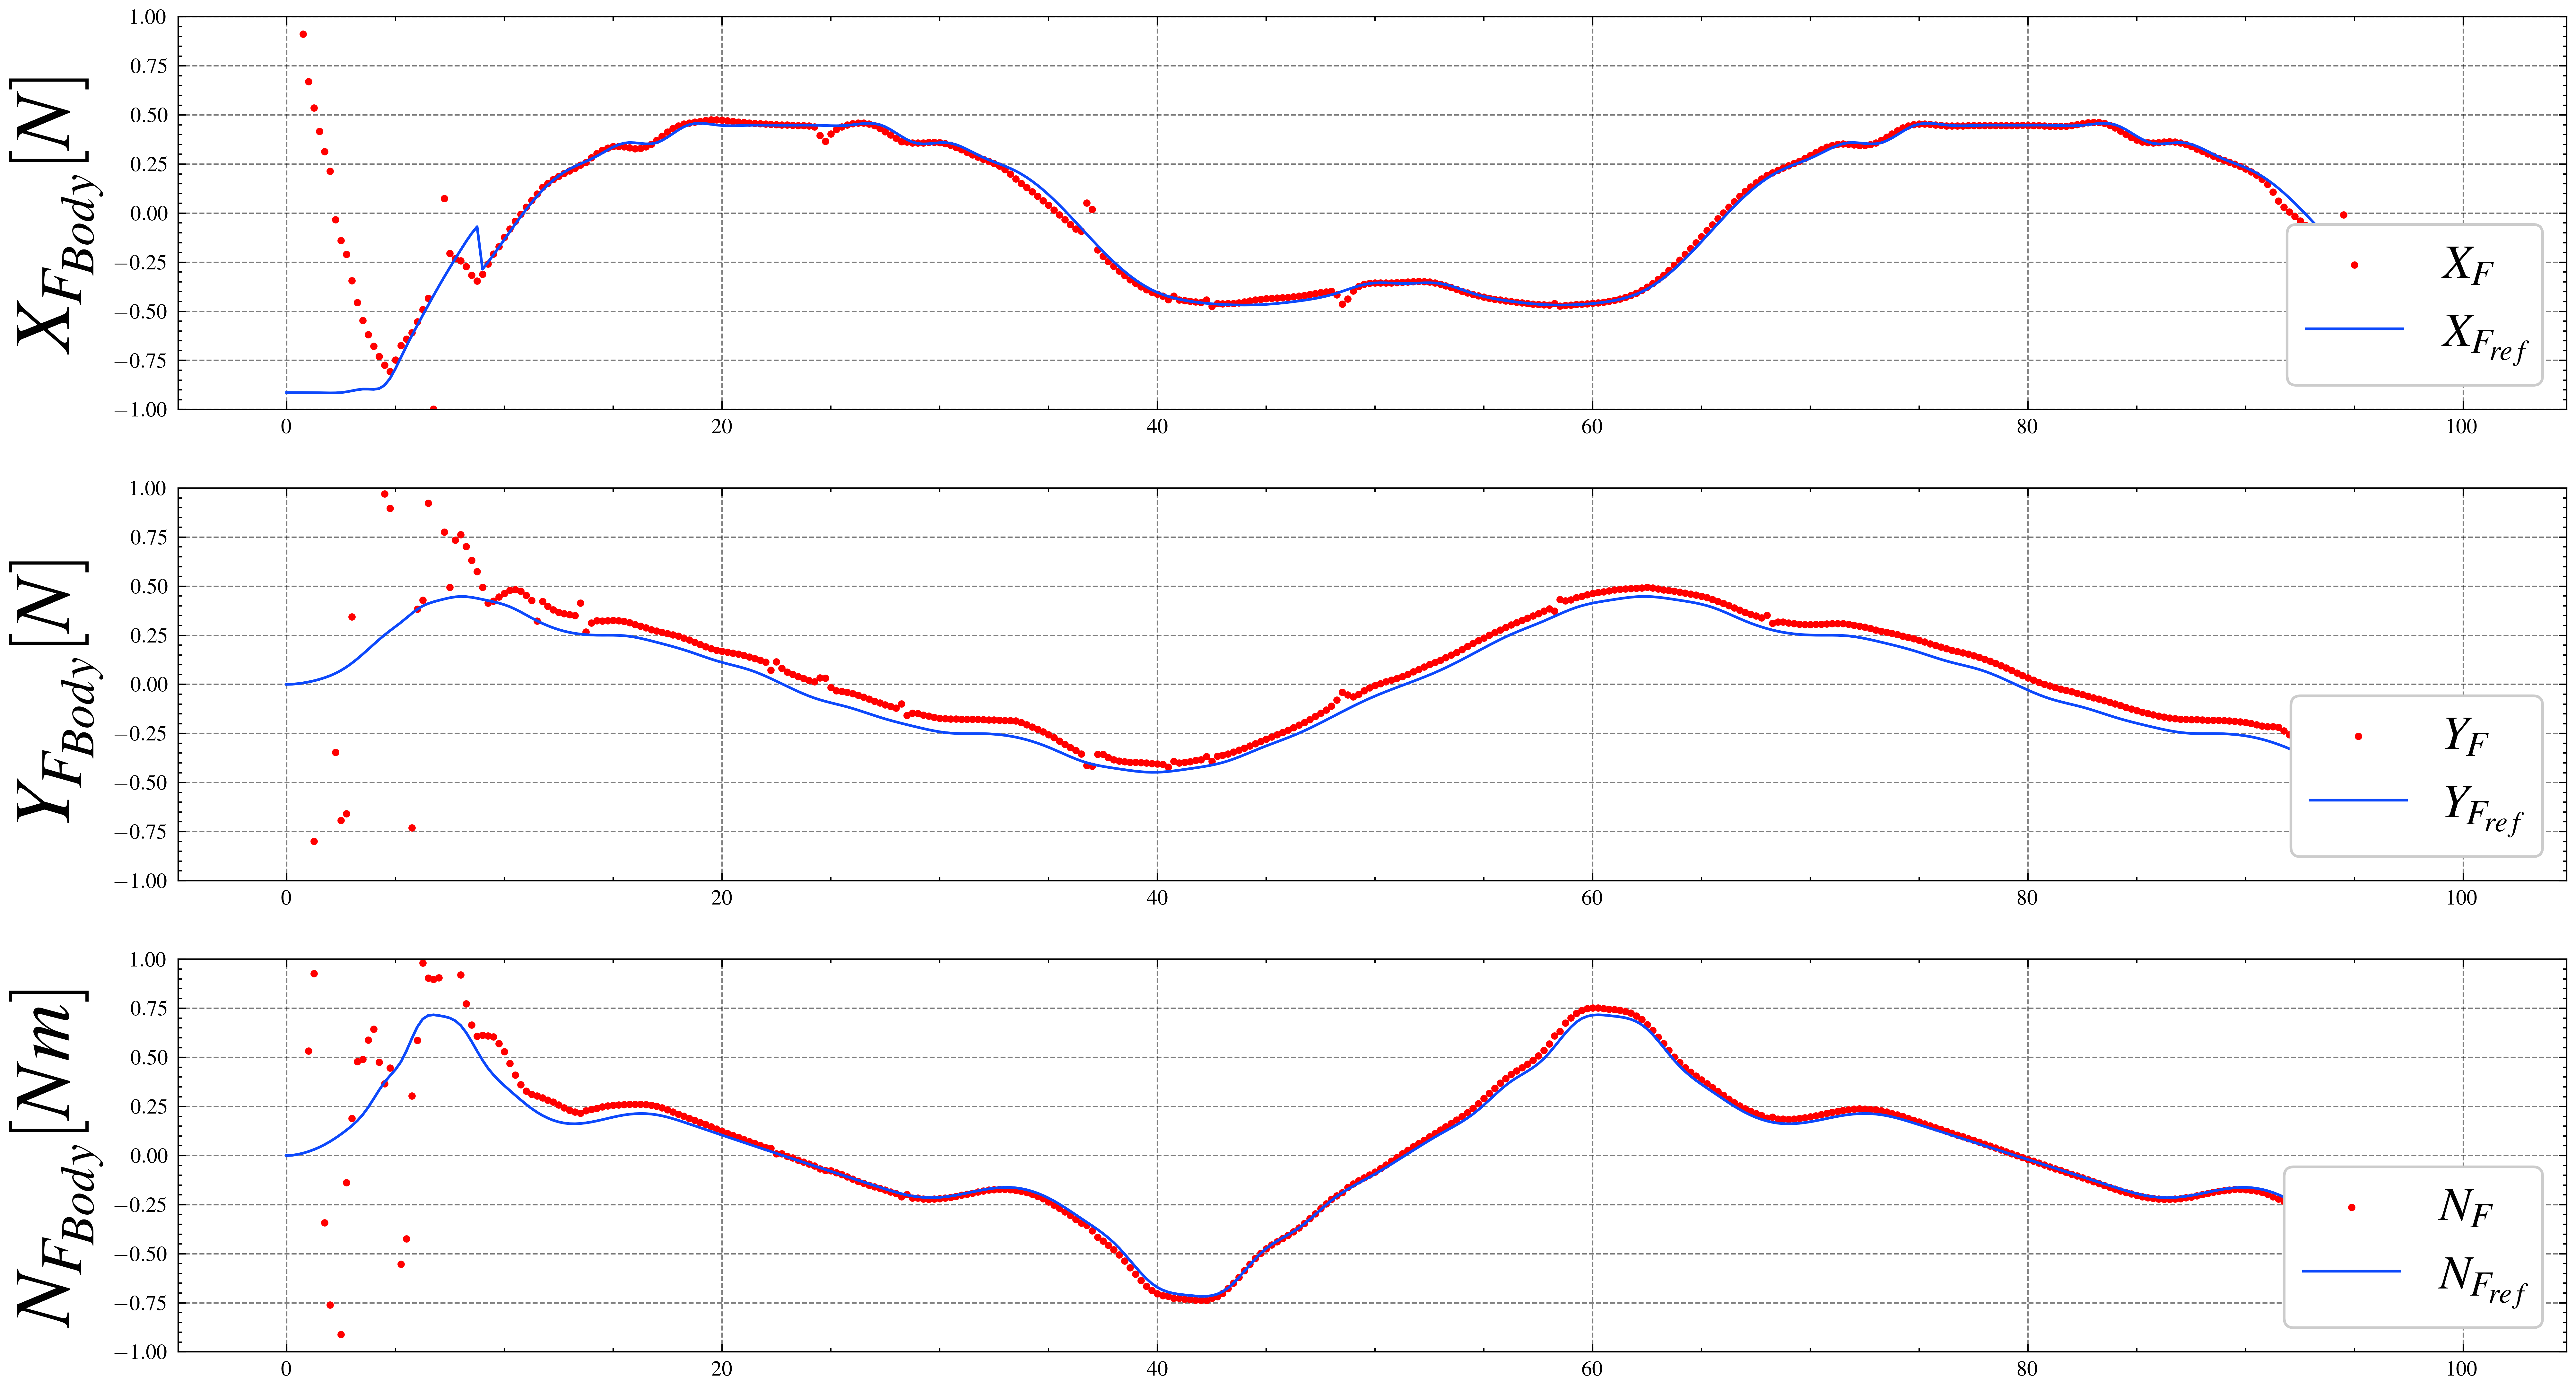

In [19]:
fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(3,1,1)
ax1.scatter(t_eval, X_F, label='$X_F$', s=3, c='red')
ax1.plot(t_eval, X_F_ref, label='$X_{F_{ref}}$')
ax1.set_ylabel('$X_{F_{Body}}[N]$', fontsize=30)
ax1.set_ylim(-1, 1)
ax1.legend(frameon=True, loc='lower right', fontsize=18)

ax2 = fig.add_subplot(3,1,2)
ax2.scatter(t_eval, Y_F, label='$Y_F$', s=3, c='red')
ax2.plot(t_eval, Y_F_ref, label='$Y_{F_{ref}}$')
ax2.set_ylabel('$Y_{F_{Body}}[N]$', fontsize=30)
ax2.set_ylim(-1, 1)
ax2.legend(frameon=True, loc='lower right', fontsize=18)

ax3 = fig.add_subplot(3,1,3)
ax3.scatter(t_eval, N_F, label='$N_F$', s=3, c='red')
ax3.plot(t_eval, N_F_ref, label='$N_{F_{ref}}$')
ax3.set_ylabel('$N_{F_{Body}}[Nm]$', fontsize=30)
ax3.set_ylim(-1, 1)
ax3.legend(frameon=True, loc='lower right', fontsize=18)

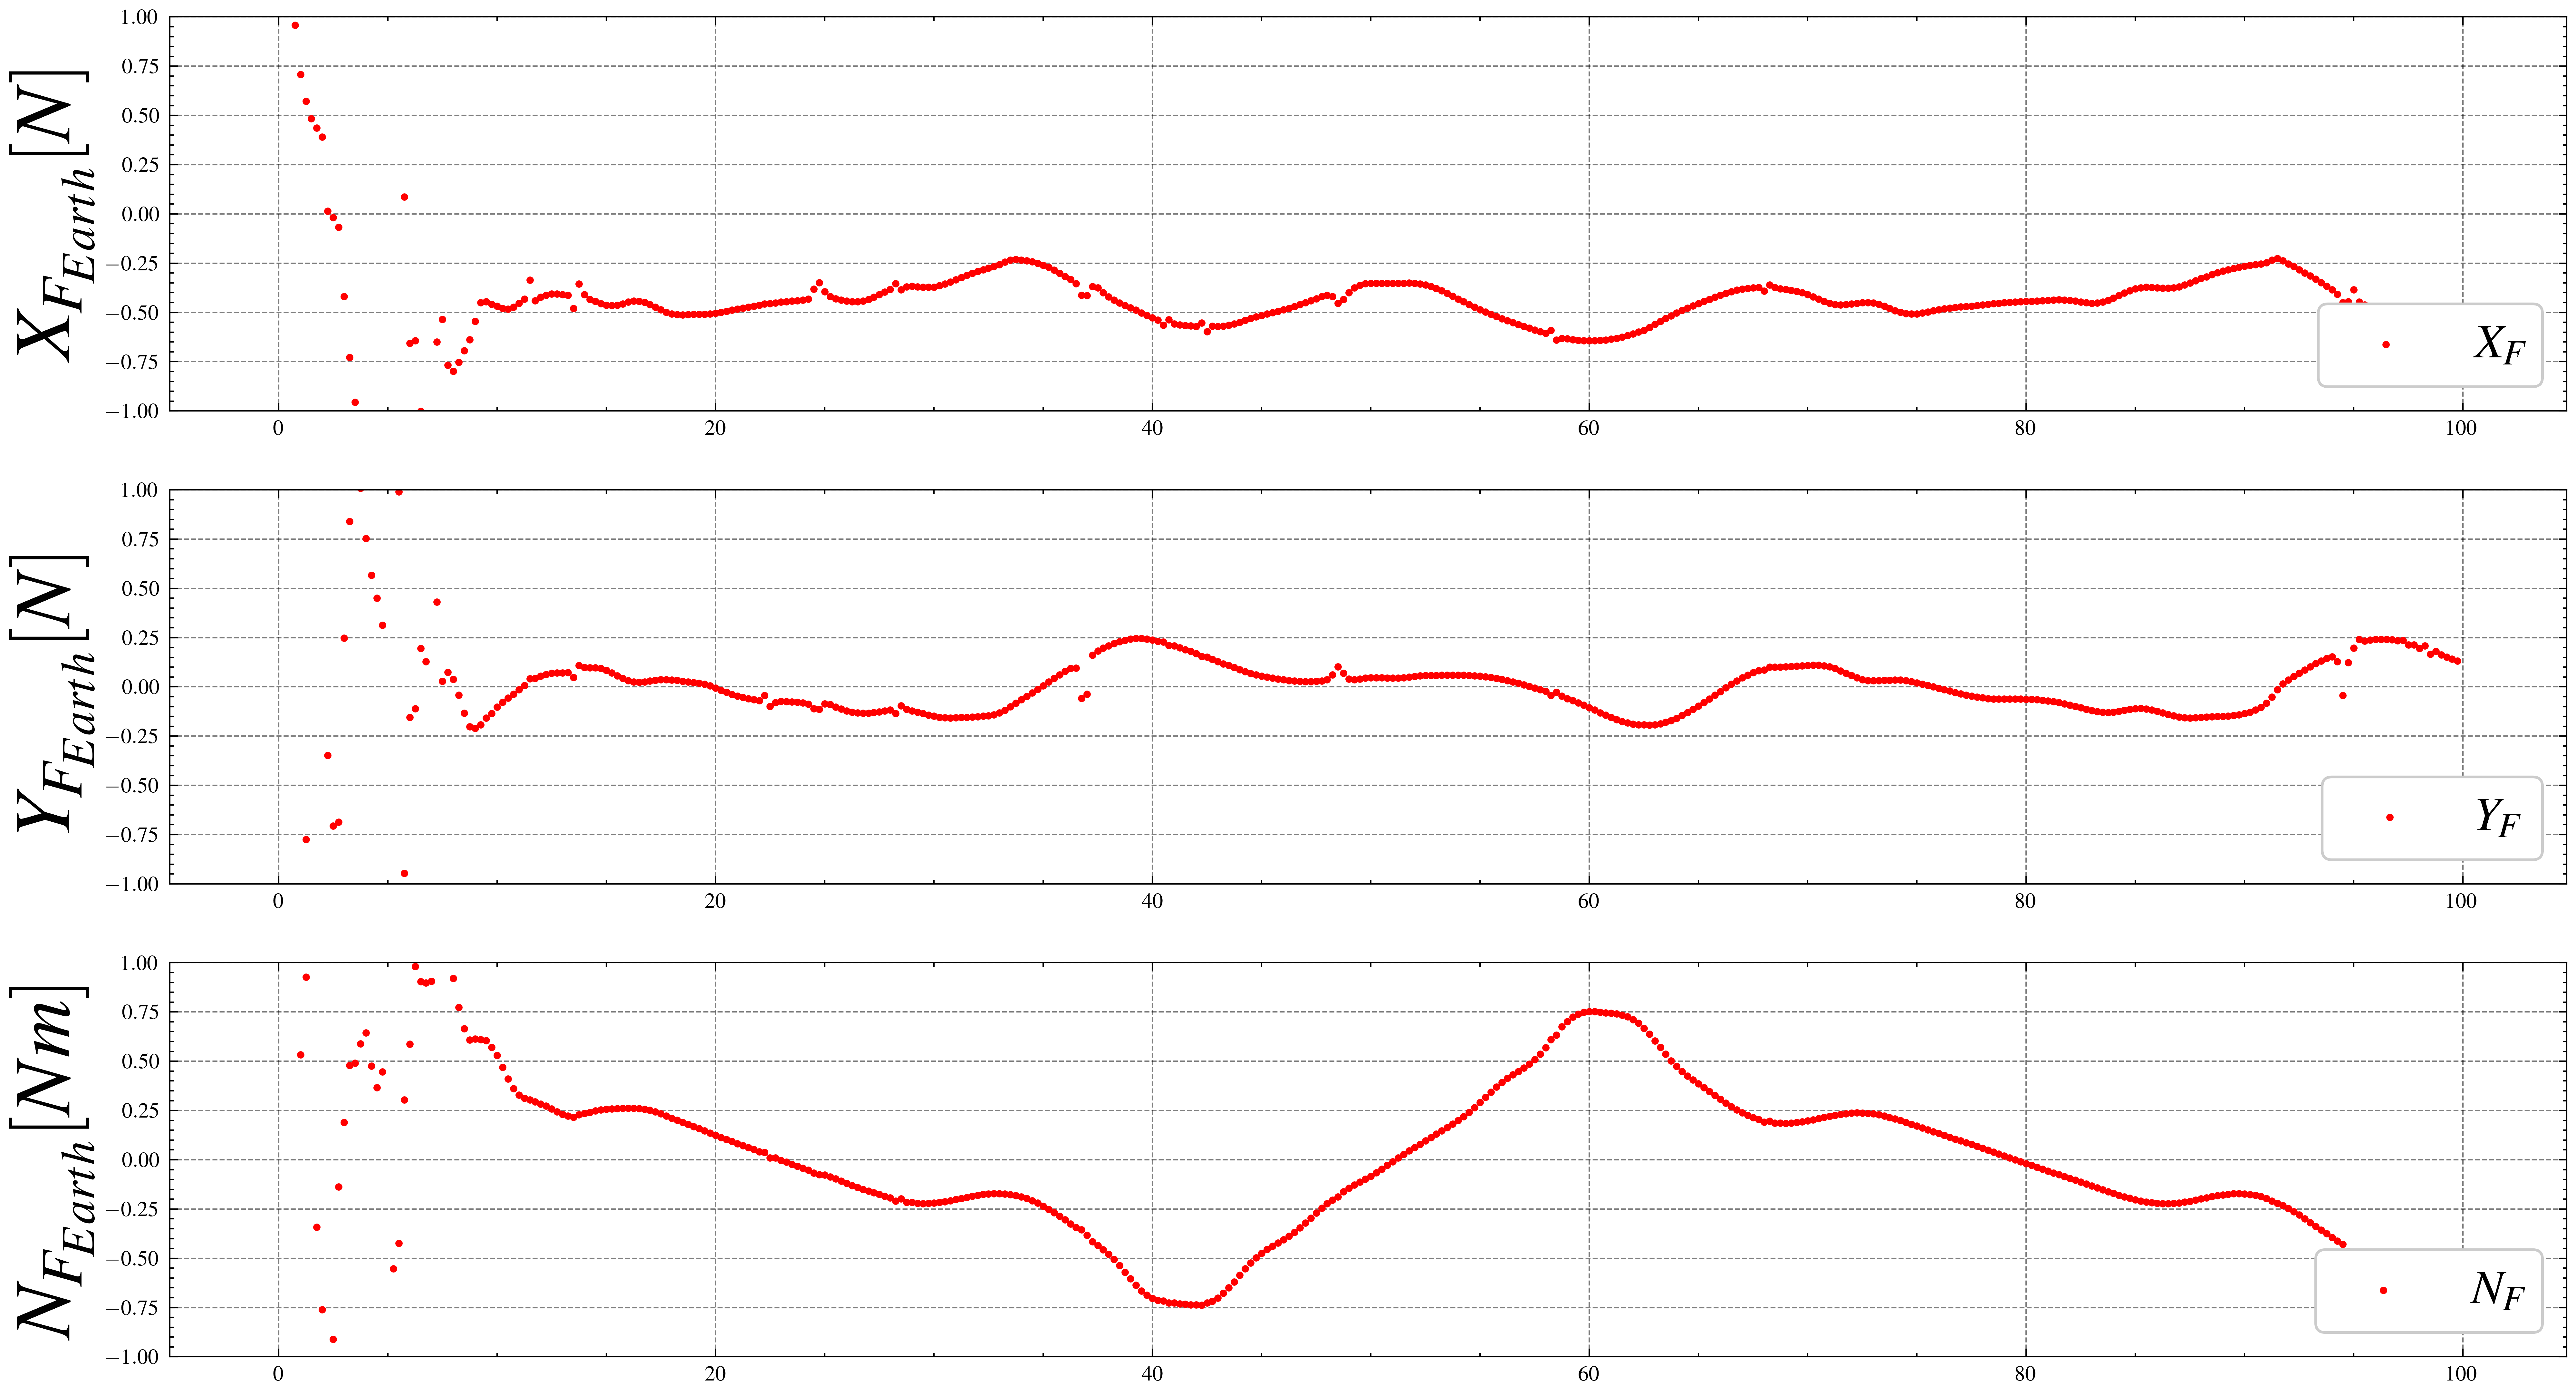

In [20]:
fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(3,1,1)
ax1.scatter(t_eval, X_F_Earth, label='$X_F$', s=3, c='red')
ax1.set_ylabel('$X_{F_{Earth}}[N]$', fontsize=30)
ax1.set_ylim(-1, 1)
ax1.legend(frameon=True, loc='lower right', fontsize=18)

ax2 = fig.add_subplot(3,1,2)
ax2.scatter(t_eval, Y_F_Earth, label='$Y_F$', s=3, c='red')
ax2.set_ylabel('$Y_{F_{Earth}}[N]$', fontsize=30)
ax2.set_ylim(-1, 1)
ax2.legend(frameon=True, loc='lower right', fontsize=18)

ax3 = fig.add_subplot(3,1,3)
ax3.scatter(t_eval, N_F_Earth, label='$N_F$', s=3, c='red')
ax3.set_ylabel('$N_{F_{Earth}}[Nm]$', fontsize=30)
ax3.set_ylim(-1, 1)
ax3.legend(frameon=True, loc='lower right', fontsize=18)

In [21]:
# df = pd.DataFrame({'time':t_eval, 'X_F_target':X_F_Earth_target, 'Y_F_target':Y_F_Earth_target, 'N_F_target':N_F_Earth_target, 'psi':psi_ref})
# df.to_csv('force_obs/suzaku_1.5EF20deg_force_target.csv')

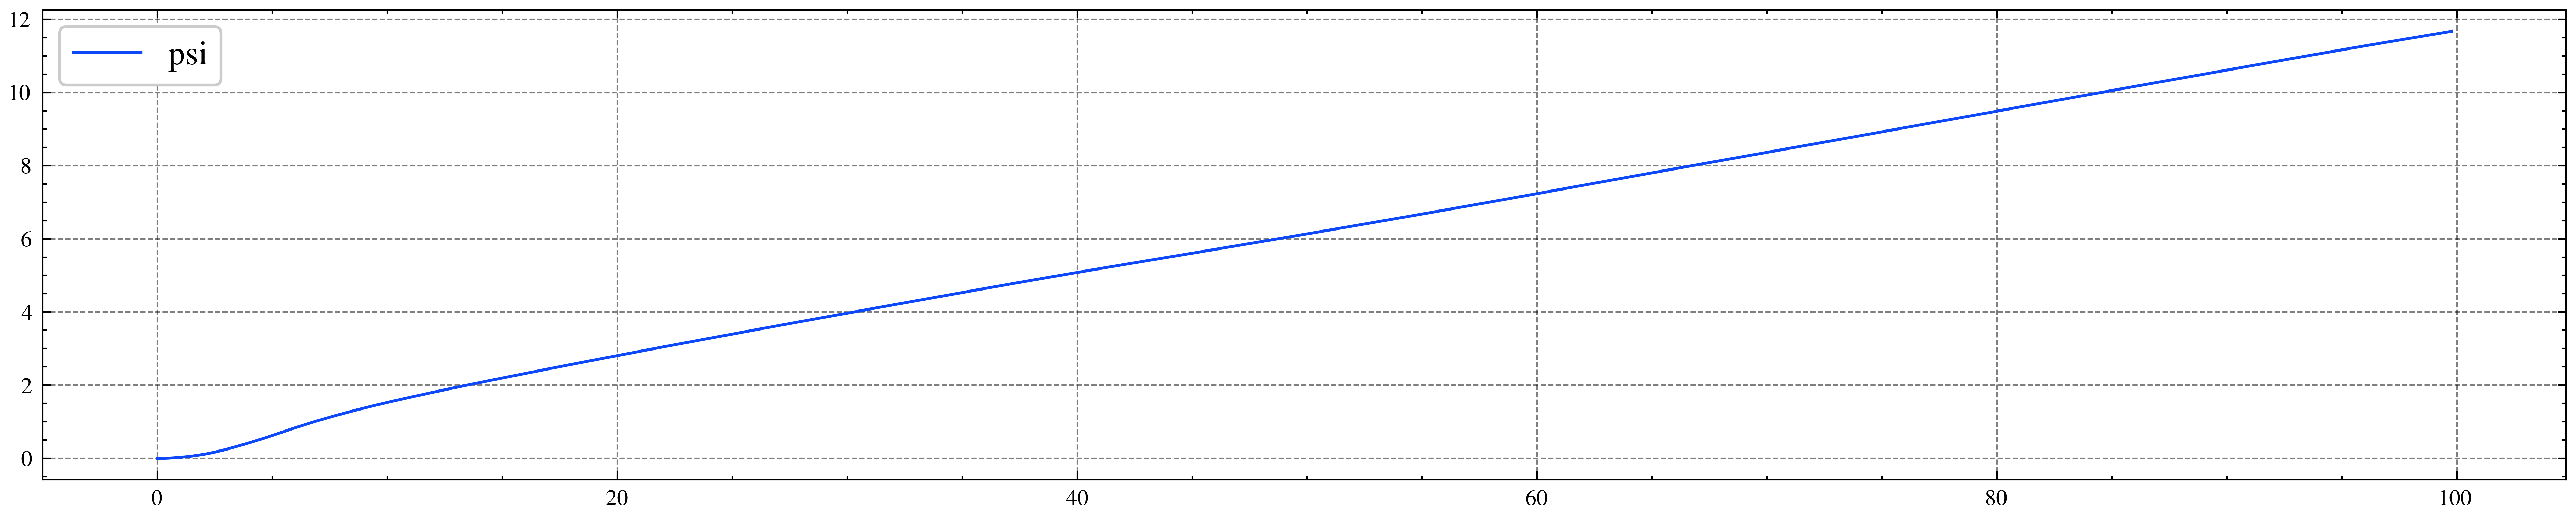

In [22]:
plt.figure(figsize=(16,3))
plt.plot(t_eval,psi,label='psi')
plt.legend(fontsize=12)

/var/folders/42/rycq9wgs5g3_yj8bjfwx0mkw0000gn/T/ipykernel_61244/324881926.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/42/rycq9wgs5g3_yj8bjfwx0mkw0000gn/T/ipykernel_61244/324881926.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


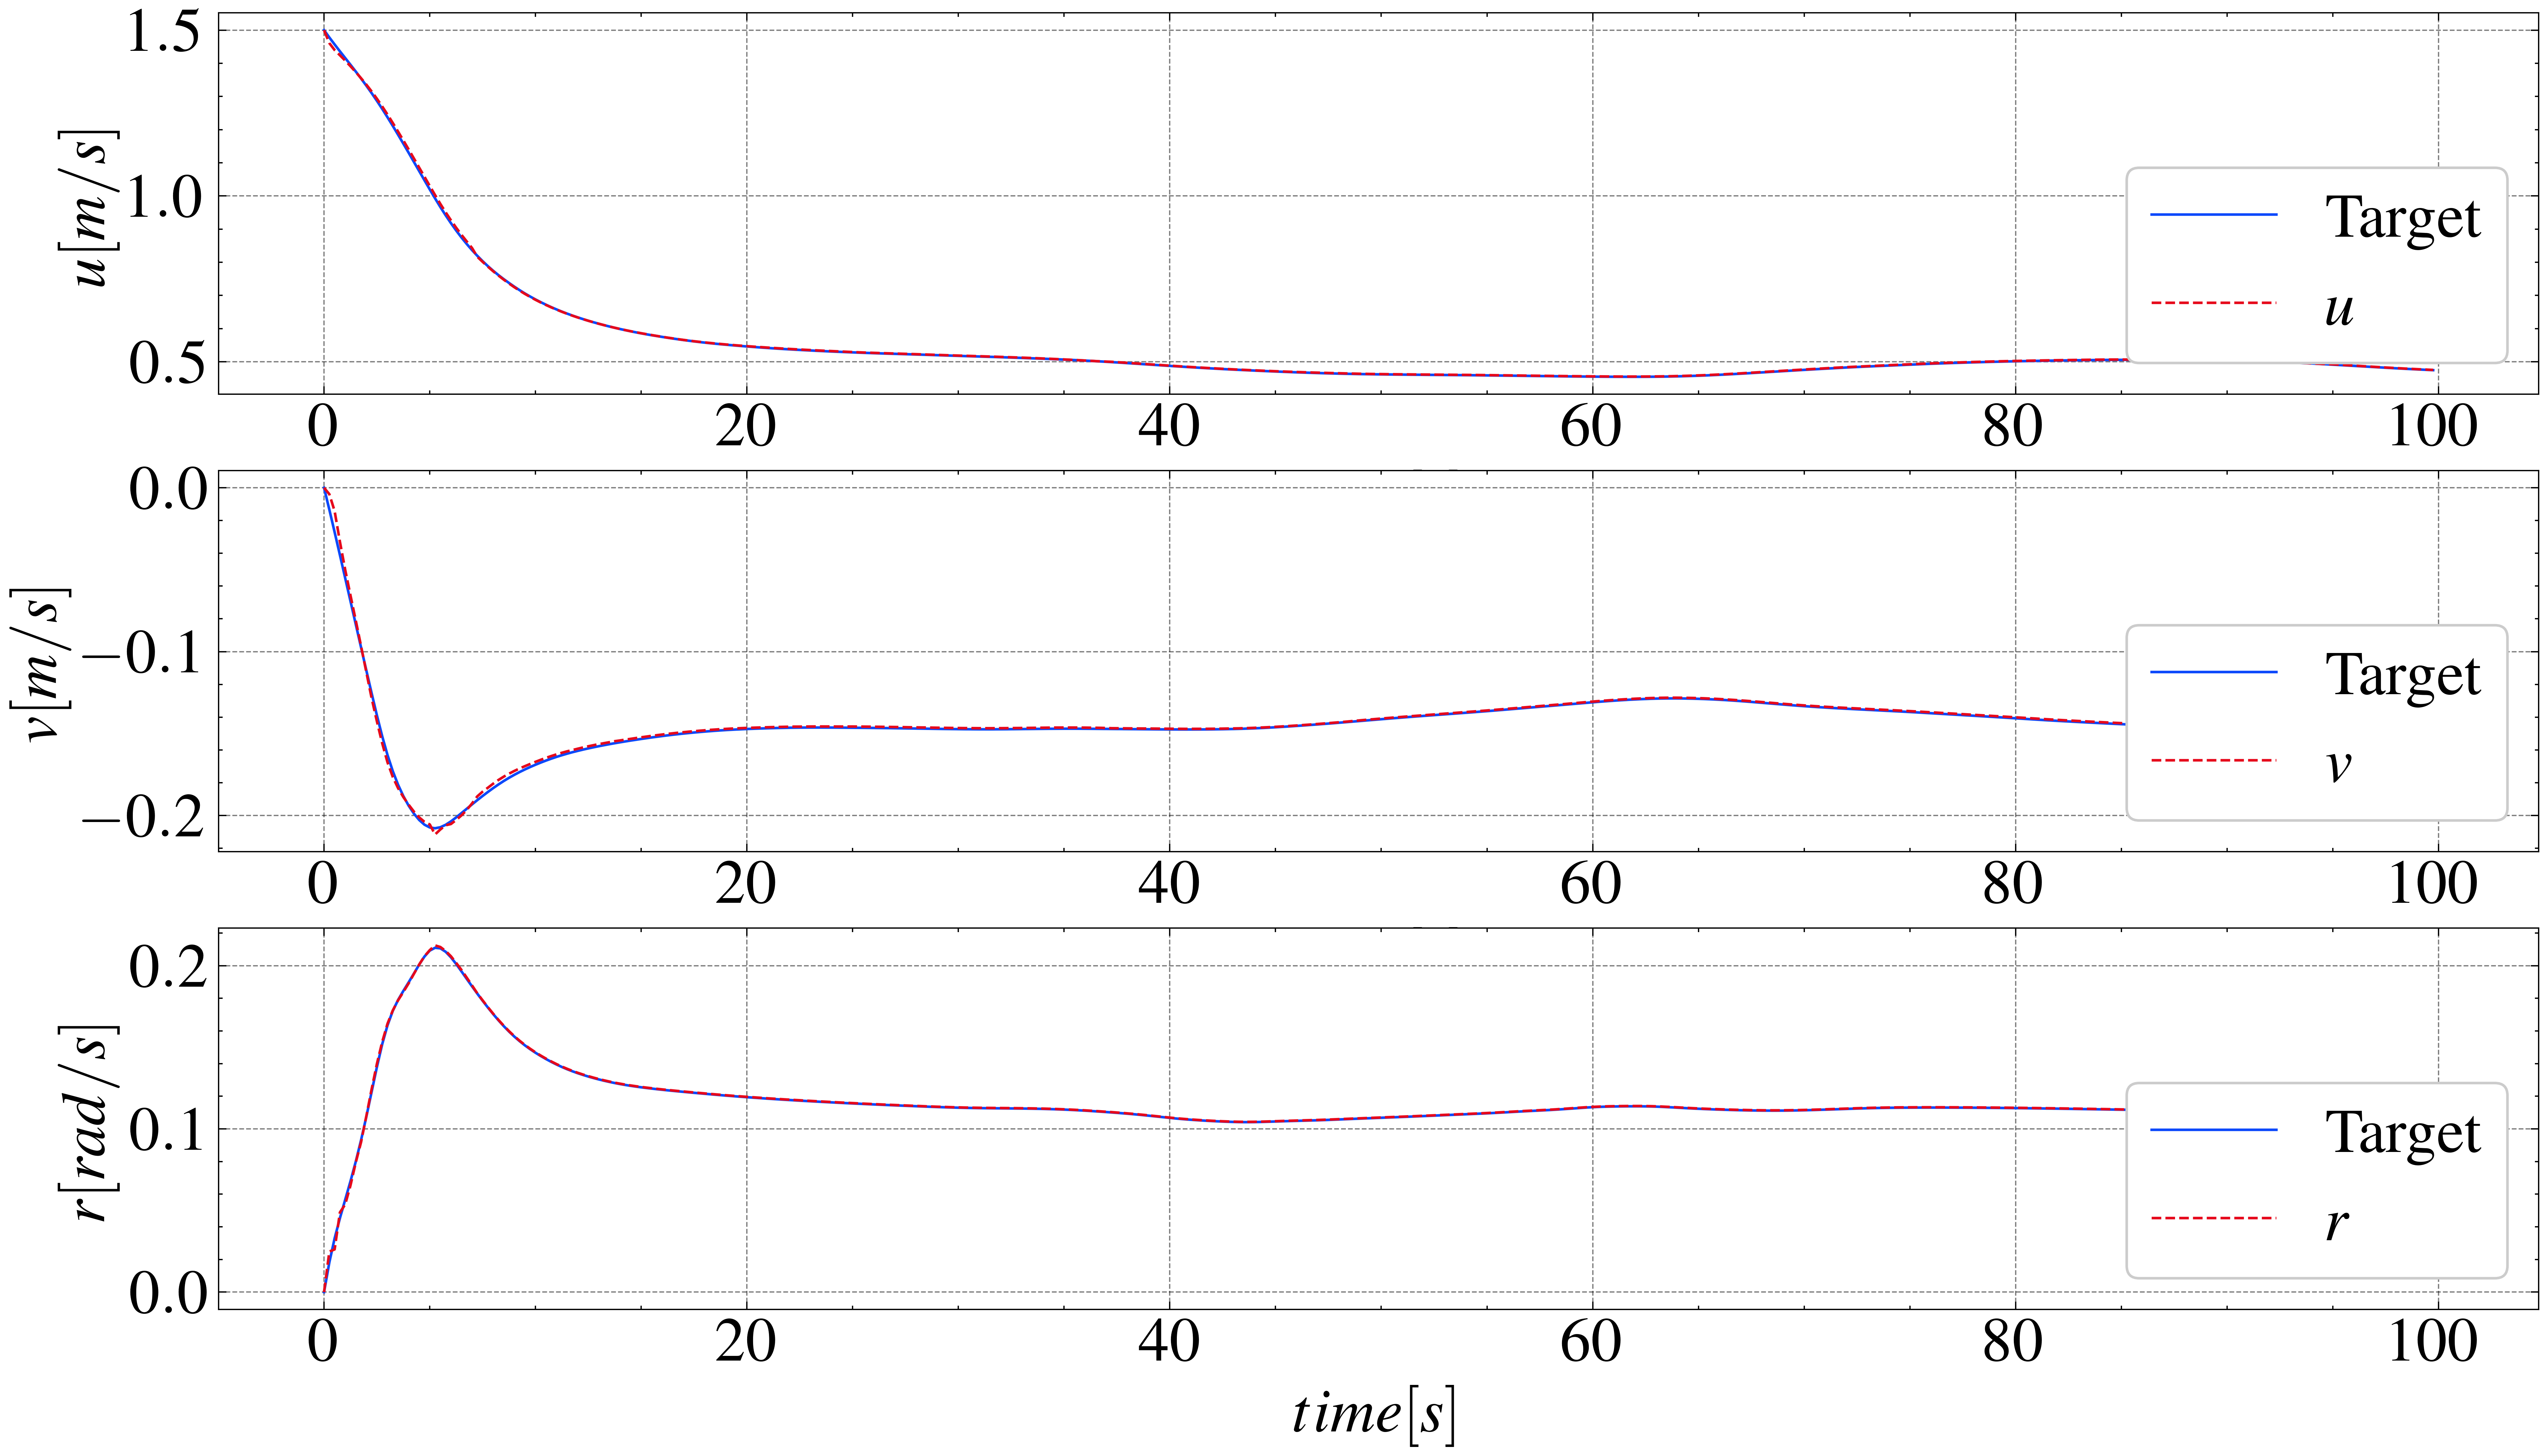

In [23]:
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(t_eval, u_ref, label='Target')
ax1.plot(t_eval, u, label='$u$')
ax1.set_xlabel('$t_eval[s]$', fontsize=24)
ax1.set_ylabel('$u[m/s]$', fontsize=24)
plt.tick_params(labelsize=24)
# ax1.set_xlim([0, 100])
ax1.legend(frameon=True, loc='lower right', fontsize=24)

ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(t_eval, v_ref, label='Target')
ax2.plot(t_eval, v, label='$v$')
ax2.set_xlabel('$t_eval[s]$', fontsize=24)
ax2.set_ylabel('$v[m/s]$', fontsize=24)
plt.tick_params(labelsize=24)
# ax2.set_xlim([0, 100])
ax2.legend(frameon=True, loc='lower right', fontsize=24)
fig.show()

ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(t_eval, r_ref, label='Target')
ax3.plot(t_eval, r, label='$r$')
ax3.set_xlabel('$time[s]$', fontsize=24)
ax3.set_ylabel('$r[rad/s]$', fontsize=24)
plt.tick_params(labelsize=24)
# ax3.set_xlim([0, 100])
ax3.legend(frameon=True, loc='lower right', fontsize=24)
fig.show()

### 外力結果の保存

In [24]:
# df = pd.DataFrame({'time':t_eval, 'X_F':X_F_Earth, 'Y_F':Y_F_Earth, 'N_F':N_F_Earth, 'psi':psi})
# df.to_csv('force_obs/suzaku_z_1.5EF20deg')